## Pràctica 8


In [62]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs
import simpy

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))

qq = "\quad "

### Exercici 1
- A una cabina experimental es genera ozó, que és un gas tòxic que volem extreure.
- Hem modelitzat l'extracció d'ozó de la següent manera:
$$x'  = -x \cdot Q/V + O \cdot R $$

on $x$ representa la concentració del gas, $Q$ representa el flux d'extracció d'aire, $V$ és el volum de l'habitació, $O$ és la concentració d'oxigen a l'aire i $R$ és el ritme de generació d'ozó.

Els valors mesurats dels paràmetres són els següents:
- La generació d'ozó es produeix a un ritme d'una molècula d'ozó per cada $(3.7 \pm 0.1) \times 10^9$ molècules d'oxigen per segon.
- La concentració d'oxigen a l'aire és de $20.9476 \pm 0.0005 \%$
- La cabina experimental té un volum de $125.4 \pm 0.8 \, m^3$


#### Dades
- Per validar el model hem fet unes proves irradiant un volum d'aire amb un extractor.
    - Volum d'aire $1.0000 \pm 1\times10^{-4} m^3$
    - Cabal d'aire de l'extractor $1.0 \pm 0.1 \,l/s$
    - La precisió de les mesures de concentració és de $1\times10^{-3}$ ppm

Index(['t (s)', 'Concentració (ppm)'], dtype='object')


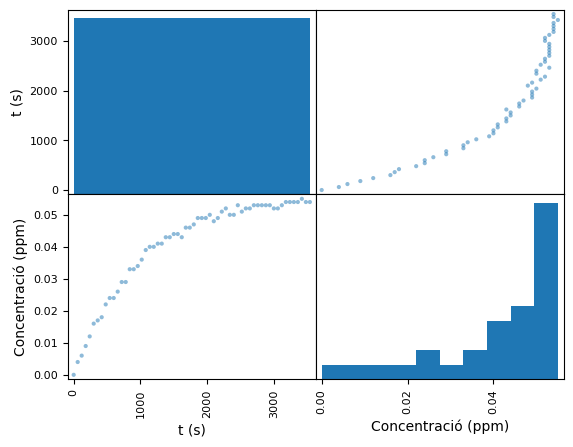

In [63]:
# Dades
data = pd.read_csv("https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/data/ozo.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

- Fes la validació del model i una anàlisi crítica considerant que l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm

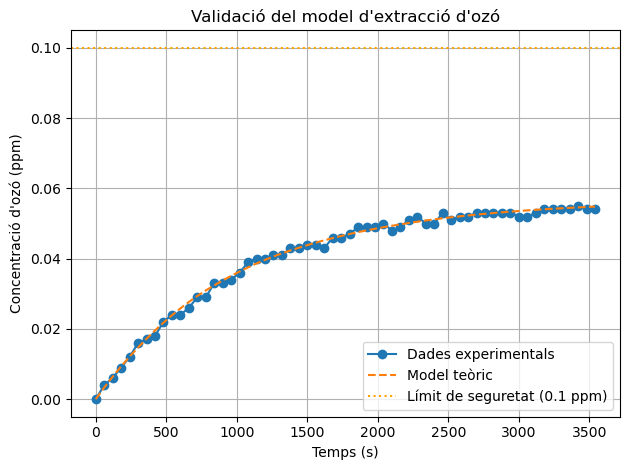

0.001 0.0001000000499999875 5.6615135135135137e-11 1.5301393841630397e-12
[0.         0.00339752 0.00661619 0.00966554 0.01255605] [0.         0.00320025 0.00619572 0.00899968 0.0116261 ]


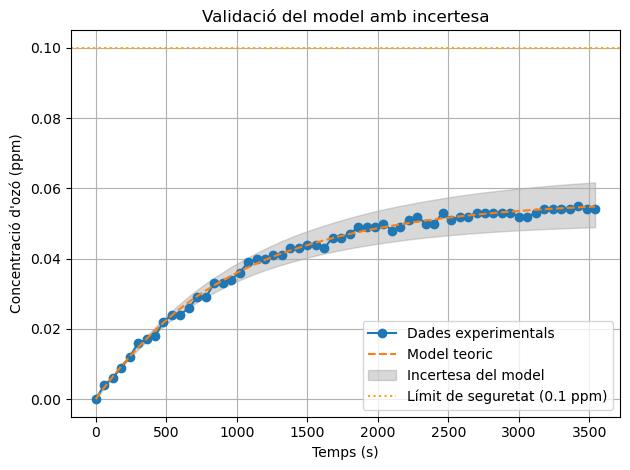

In [64]:
# si s'hagues de resoldre numericament la integral i no es pogues fer amb simpy
from scipy.integrate import odeint

#Extraemos los datos aportados
df = data.copy()

# Definimos las variables simbólicas con incertidumbre
Q_val, Q_err = 1.0e-3, 0.1e-3  # m^3/s (de 1.0 l/s ± 0.1 l/s)
V_val, V_err = 1.000, 1e-4  # m^3 ± 0.8
O_val, O_err = 20.9476 / 100, 0.0005 / 100  # porcentaje a fracción
R_ratio_val, R_ratio_err = 1 / (3.7e9), 0.1e9 / (3.7e9)**2  # 1 / (3.7e9) ± ...


k = Q_val / V_val
OR = O_val * R_ratio_val

def model(x,t):
    return -k * x + OR

x0 = 0.0  # Concentración inicial de ozono

t = df['t (s)'].values  # Tiempo en segundos
# Resolvemos la ecuación diferencial
x_model = odeint(model, x0, t).flatten()

# Convertimos a DataFrame para facilitar el manejo
df["Model (ppm)"] = x_model * 1e6  # Convertimos a ppm (partes por millón)


# Graficamos los resultados
plt.plot(df["t (s)"], df["Concentració (ppm)"], label="Dades experimentals", marker='o')
plt.plot(df["t (s)"], df["Model (ppm)"], label="Model teòric", linestyle="--")
plt.axhline(0.1, color="orange", linestyle=":", label="Límit de seguretat (0.1 ppm)")
plt.xlabel("Temps (s)")
plt.ylabel("Concentració d'ozó (ppm)")
plt.title("Validació del model d'extracció d'ozó")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# calcul incerteses

k_val = Q_val / V_val
# Error propagation for k
# k_r = sqrt( (C_Q * Q_err)^2 + (C_V * V_err)^2 )
k_err =  np.sqrt((1 / V_val * Q_err)**2 + (-Q_val / V_val**2 * V_err)**2)
OR_val = O_val * R_ratio_val
# Error propagation for OR
OR_err = np.sqrt((R_ratio_val * O_err)**2 + (O_val * R_ratio_err)**2)
print(k_val, k_err, OR_val, OR_err)

# analisi critic
t = df["t (s)"].values
x0 = 0.0

# Curva por debajo del modelo
k_max = k_val + k_err
OR_min = OR_val - OR_err
# Curva por encima del modelo
k_min = k_val - k_err
OR_max = OR_val + OR_err

def model_min(x, t):
    return -k_max * x + OR_min

def model_max(x, t):
    return -k_min * x + OR_max

def model_center(x, t):
    return -k_val * x + OR_val

x_model = odeint(model_center, x0, t).flatten() * 1e6  # Concentración teórica del modelo central
x_lower = odeint(model_min, x0, t).flatten() * 1e6  # a ppm
x_upper = odeint(model_max, x0, t).flatten() * 1e6  # a ppm
print(x_upper[:5], x_lower[:5])



plt.plot(t, df["Concentració (ppm)"], label="Dades experimentals", marker='o')
plt.plot(t, x_model, label="Model teoric", linestyle="--")
plt.fill_between(t, x_lower, x_upper, color="gray", alpha=0.3, label="Incertesa del model")
plt.axhline(0.1, color="orange", linestyle=":", label="Límit de seguretat (0.1 ppm)")
plt.xlabel("Temps (s)")
plt.ylabel("Concentració d'ozó (ppm)")
plt.title("Validació del model amb incertesa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
# si es pot fer amb simpy

from sympy.abc import t,Q,V,O,R

# Creem la x com a funció del temps
x = sp.Function('x')(t) # x(t), la concentració serà funció del temps t

# Diferencial d'x respecte al temps
dx = sp.diff(x,t) # x prima que ens servirà per a definir l'equació diferencial, usant x(t)

# Definim la equació diferencial que se'ns dona a l'enuncialt
fx = -x*Q/V+O*R # RHS de l'equació diferencial, al que equival la taxa de canvi
eq = sp.Eq(dx, fx) # Muntem l'equació diferencial, igualant la derivada a la funció de taxa de canvi

# Definim la condició inicial
ics = {x.subs(t, 0): 0} # Concentració inicial 0

# Resolem l'equació diferencial, per a "x", usant les condicions inicials
sol = sp.dsolve(eq, x, ics=ics) # resolem l'equació diferencial amb les condicions inicials per x(t)
show("solution:  ", sol)

ppm = 1e6 # ppm, parts per milió, per a convertir la concentració a ppm
xt = sol.rhs * ppm # El valor x en funció del temps t
show(xt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [66]:
# Defimim el valor de les variables que se'ns dona a l'enunciat
valors = {Q: 1.0*1e-3,
          V: 1.0000,
          O: 20.9476/100,
          R: 1/(3.7*1e9)}

xt_subs = xt.subs(valors)
xt_subs

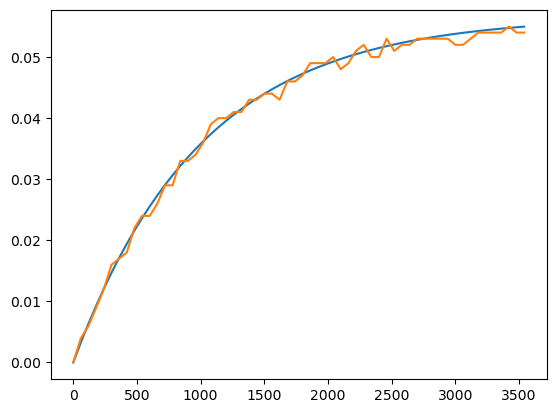

In [67]:
# Lambdify indicant que donarem valors numèrics a les variables, i indiquem que volem que ens quedi en funció de t, per tant substituïm per diferents valors de t
fxt = sp.lambdify(t,xt_subs)

# Obtenim els temps de la taula de dades
times = data['t (s)']

pred = fxt(times) # Obtenim les prediccions de la concentració per a cada temps
plt.plot(times, pred)
plt.plot(times, data['Concentració (ppm)'])
plt.show()

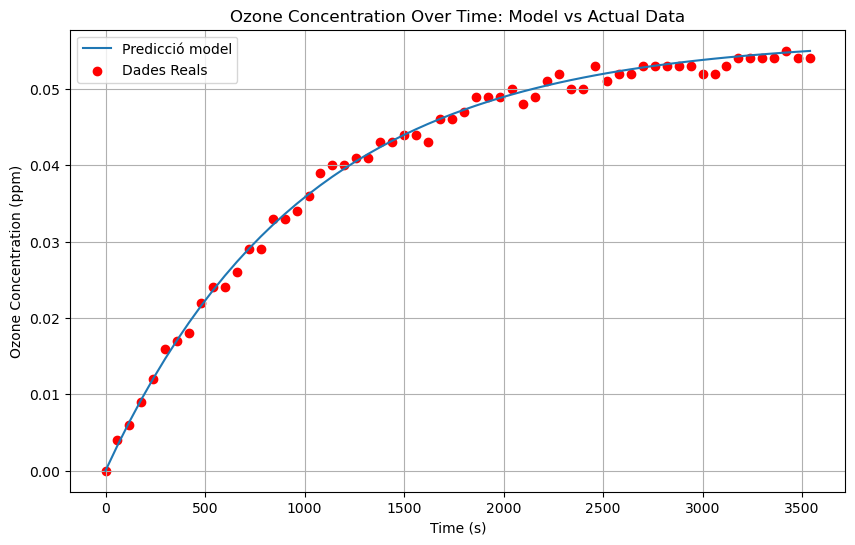

In [68]:
# més bonic
# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, pred, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)

Discrepànica: E = S - D

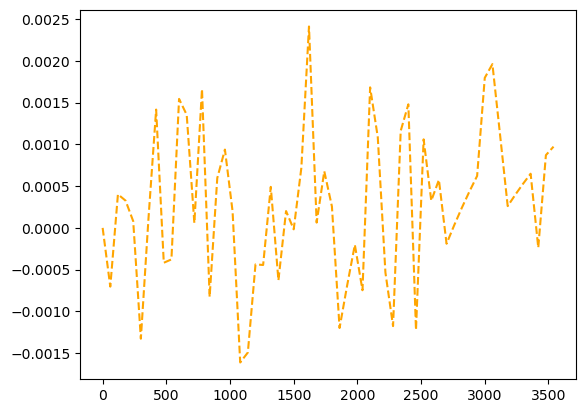

In [69]:
# E_p és l'error entre el real i el model (discrepancies)
E_p = pred - data['Concentració (ppm)']
plt.plot(times, E_p, label='Discrepancies', color='orange', linestyle='--')


Mean discrepancy: 0.0002715894874116025


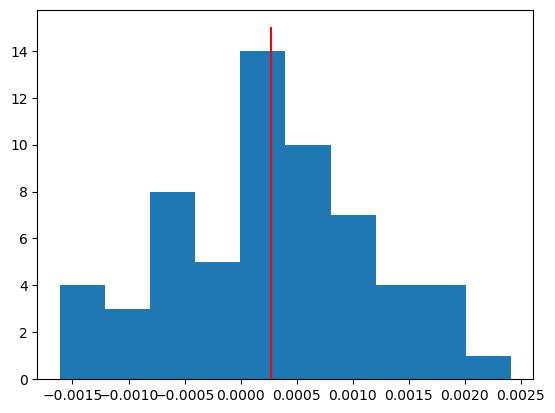

In [70]:
mean_discrepancy = np.mean(E_p)
plt.hist(E_p)
plt.vlines(mean_discrepancy, color='red', label='Mean Discrepancy', ymin=0, ymax=15)
print("Mean discrepancy:", mean_discrepancy)

$$c_i=\frac{x_i}{r}\frac{\partial r}{\partial x_i}$$

In [71]:
# ara passem a calcular les incerteses del nostre model
# per calcular les incerteses I = c*(u_x/x): 
# on u_x/x es la U_relativa de la variable x
# c = x/r * dr/dx on r = funcio
# x = valors de la nostra funcio

# NO DIVIDIM ENTRE xt (r) ja que estem calculant la incertesa absoluta
# si volguessim calcular la incertesa relativa, dividiríem entre xt
# exemple = Coef_V = (V/xt*sp.diff(xt,V))


Coef_V = (V*sp.diff(xt,V))
show(Coef_V)

Coef_Q = (Q*sp.diff(xt,Q))
show(Coef_Q)

Coef_O = (O*sp.diff(xt,O))
show(Coef_O)

Coef_R = (R*sp.diff(xt,R))
show(Coef_R)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [72]:
# Agafem els coeficients de la fase experimental
# calculem la incertesa relativa de cada variable

IVr = 0.0001/1
IQr = 1e-4/0.001
IOr = 5e-6/0.209476

# FALTA EXPLICAR QUAN ES FA **2 I QUAN ES DEIXA IGUAL
IRr = 0.1/(3.7**2*1e9)/(1/3.7e9) 
print(IVr, IQr, IOr, IRr)

0.0001 0.1 2.3869082854360408e-05 0.027027027027027025


In [73]:
Cur_Q = Coef_Q * IQr
Cur_V = Coef_V * IVr
Cur_O = Coef_O * IOr
Cur_R = Coef_R * IRr
urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R**2

show("urXt^2_C=", urXt2)

<IPython.core.display.Math object>

In [74]:
up2 = urXt2.subs(valors)
up2 = sp.lambdify(t,up2)
up2 = up2(data['t (s)'])

In [75]:
# uV incertesa absoluta de la xt
# uD incetesa absoluta dades 
# up2 incertesa absoluta del model
uD = 1e-3
uV = np.sqrt(uD**2 + up2)
print(up2)

0     0.000000e+00
1     8.036189e-09
2     3.135559e-08
3     7.016308e-08
4     1.259630e-07
5     2.010084e-07
6     2.978901e-07
7     4.192366e-07
8     5.675016e-07
9     7.448220e-07
10    9.529285e-07
11    1.193098e-06
12    1.466136e-06
13    1.772386e-06
14    2.111746e-06
15    2.483709e-06
16    2.887398e-06
17    3.321617e-06
18    3.784889e-06
19    4.275512e-06
20    4.791596e-06
21    5.331111e-06
22    5.891921e-06
23    6.471825e-06
24    7.068585e-06
25    7.679958e-06
26    8.303719e-06
27    8.937684e-06
28    9.579724e-06
29    1.022779e-05
30    1.087990e-05
31    1.153420e-05
32    1.218891e-05
33    1.284236e-05
34    1.349301e-05
35    1.413941e-05
36    1.478024e-05
37    1.541427e-05
38    1.604042e-05
39    1.665768e-05
40    1.726515e-05
41    1.786205e-05
42    1.844768e-05
43    1.902144e-05
44    1.958281e-05
45    2.013135e-05
46    2.066670e-05
47    2.118858e-05
48    2.169676e-05
49    2.219109e-05
50    2.267147e-05
51    2.313784e-05
52    2.3590

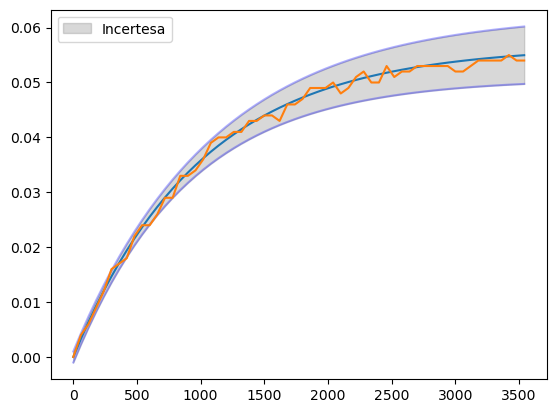

In [76]:
plt.plot(data['t (s)'],pred+uV,color='blue',alpha=0.3)
plt.plot(data['t (s)'],pred)
plt.plot(data['t (s)'],pred-uV,color='blue',alpha=0.3)
plt.fill_between(data['t (s)'],
                 pred - uV,
                 pred + uV,
                 color='gray', alpha=0.3, label='Incertesa')
plt.plot(data['t (s)'],data['Concentració (ppm)'])
plt.legend()
plt.show()

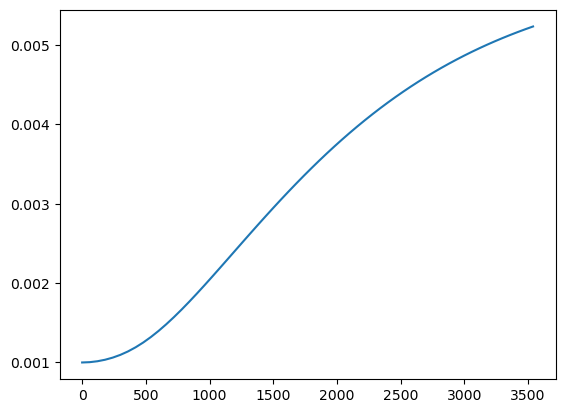

In [77]:
#incertesa absoluta
plt.plot(data['t (s)'],uV)
plt.show()

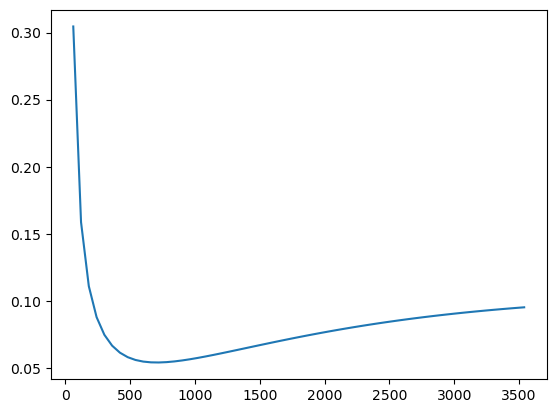

In [78]:
#incertesa relativa
plt.plot(data['t (s)'],uV/pred)
plt.show()

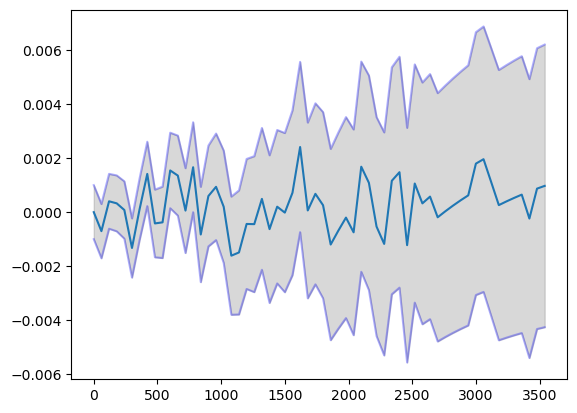

In [79]:
#error del model 
plt.plot(data['t (s)'],E_p+uV,color='blue',alpha=0.3)
plt.plot(data['t (s)'],E_p)
plt.plot(data['t (s)'],E_p-uV,color='blue',alpha=0.3)
plt.fill_between(data['t (s)'],
                 E_p - uV,
                 E_p + uV,
                 color='gray', alpha=0.3, label='Incertesa')
plt.show()

### OPCIO 1
Si l'enunciat dona 5 +- 0.1 ppm



Notem que l'incertesa evoluciona i s'estabilitza al voltant de $0.1$, $10$%.

L'enunciat ens diu: *l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm*. Això ens està demanant tenir una incertesa relativa sobre $x(t)$ del $\frac{0.1 ppm}{5 ppm} = 0.02$, $2$%.

La incertesa estàndard relativa representa una desviació estàndard: $\sigma = \frac{u(x)}{x}$

Hem de trobar un nivell de confiança del 95% en quin interval es pot trobar la incertesa de la concentració d'ozó. Per passar la desviació estàndard a un interval de confiança del 95%, cal multiplicar pel factor de cobertura estadística, aprozimem que $z(95\%) = 2$

Per tant, busquem que: $x \pm 2u(x) = 5 \pm 0.1$ ppm
- $2\frac{u(x)}{x} \le 0.02 \to \frac{u(x)}{x} \le 0.01$

### OPCIO 2
Si l'enunciat dona 5ppm i 0.1 ppm com a valors diferents

Ara mirem quan el valor d'ozó de la cabina supera 0.1 i 5ppm, amb les dades reals, no del experiment.

In [80]:
valors = {V: 125.4, Q: 0.001, O: .209476, R: 1/3.7e9}
xt_subs = xt.subs(valors)
xt_subs

Text(0.5, 0, 'Temps (s)')

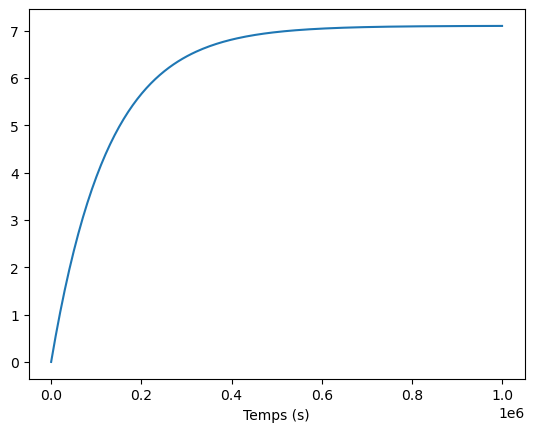

In [81]:
fxt = sp.lambdify(t,xt_subs)
temps = np.linspace(0, 1000000, 200)
pred = fxt(temps)
plt.plot(temps, pred)
plt.xlabel("Temps (s)")

Efectivament supera els 2 valors.

Trobem un interval per saber quan passa.

In [82]:
Coef_V = (V*sp.diff(xt,V))
show(Coef_V)

Coef_Q = (Q*sp.diff(xt,Q))
show(Coef_Q)

Coef_O = (O*sp.diff(xt,O))
show(Coef_O)

Coef_R = (R*sp.diff(xt,R))
show(Coef_R)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [83]:
IVr = 0.8/125.4
IQr = 1e-4/0.001
IOr = 5e-6/0.209476
IRr = 0.1/(3.7**2*1e9)/(1/3.7e9)
print(IVr, IQr, IOr, IRr)

0.006379585326953748 0.1 2.3869082854360408e-05 0.027027027027027025


In [84]:
Cur_Q = Coef_Q * IQr
Cur_V = Coef_V * IVr
Cur_O = Coef_O * IOr
Cur_R = Coef_R * IRr

urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R**2
show("urXt^2_C=", urXt2)

<IPython.core.display.Math object>

In [85]:
up2 = urXt2.subs(valors)


In [86]:
uD = 1e-3

uV = (uD**2 + up2)**0.5

In [87]:
alt = xt_subs + uV
baix = xt_subs - uV

In [88]:
# Per 0.1
b01 = sp.nsolve(sp.Eq(baix, 0.1), t, 1000)
a01 = sp.nsolve(sp.Eq(alt, 0.1), t, 1000)
m01 = sp.nsolve(sp.Eq(xt_subs, 0.1), t, 1000)
print("Temps per 0.1 ppm", b01, m01, a01)

Temps per 0.1 ppm 1831.87194699175 1778.86981828567 1728.51184921765


In [89]:
# Per 5
b5 = sp.nsolve(sp.Eq(baix, 5), t, 15000)
a5 = sp.nsolve(sp.Eq(alt, 5), t, 15000)
m5 = sp.nsolve(sp.Eq(xt_subs, 5), t, 15000)
print("Temps per 5 ppm", b5, m5, a5)

Temps per 5 ppm 173547.538814019 152776.376102856 138623.049778958


### Exercici 2

Tenim un taller en el qual hi ha 5 màquines idèntiques que processen tasques que arriben de forma aleatòria cada 12 minuts de mitjana.
Les tasques s’assignen a qualsevol màquina que estigui lliure, o fan cua esperant que hi hagi alguna màquina lliure.
El temps necessari per completar una tasca també és aleatori, però de mitjana es triga una hora per a totes les tasques i màquines.

Al taller hi treballen 3 operaris, que tenen dues feines principals:

- Preparar les màquines perquè inicien la tasca que ha arribat.

- Reparar una màquina que ha fallat.

La preparació de la tasca necessita un temps aleatori, però que de mitjana és de 20 minuts.
La reparació necessita dos operaris i un temps aleatori, que de mitjana és de mitja hora.
Quan ha finalitzat una tasca, el 20% dels cops cal reparar la màquina.

- Fes 10 simulacions d'una setmana i calcula la llargària mitjana de la cua de tasques.

- Què faries per reduir la cua de tasques i per què?


### Resum

Recursos:
- Màquines x5
- Tècnics x3

Processos:
- Processar tasca
    - sí trencat
    - no trencat
- Arribada
- Reparació
- Carregar

Relacions:
- Arr -> Carr -> Process
    - Process -> Carr
    - Process -> Reparar -> Carr
    
Demanen: Llarg Cua
Tenim Log (pd) on anem guardant la llargària de la cua




### Apunts
- Definim processos com funcions amb statements `yield`. SimPy va a través d'aquests pel temps

En cada `yield`:
- **Pausa** el procés
- Espera **passi** cert esdeveniment
- Quan passa, continua a partir d'allà

Els **recursos** es comparteixen entre tot l'entorn:
- **Definim** amb: `resource = simpy.Resource(env, capacity=CAPACITY)`
-  Podem **demanar** el recurs amb `with resource.request() as req`
-  El procés s'**allibera** automàticament quan sortim del **bloc** `with`
   -  **COMPTE**: A vegades no ho sembla/ sembla que ho alliberem però s'ha cridat una **coupled function**... difícil traçar execució

A tenir en compte pels diferents processos:
- `yield env.timeout(...)`: Pausa el procés fins al **temps simulat** avança al desitjat (`...`)
- `env.process(...)`: Crea un **nou SimPy process** (corrutina) $\to$ permet correr en **paralel**
  - A arribades no va acompanyat de `yield` perquè continuen arribant de forma contínua
  - A la resta de procesos sí, perquè per a donar per "acabat" cert procés han d'acabar els de dins
- Combinació:
    ```
    with resource.request() as r:
        yield r
    ```
    - Crea la **request** i pausa el procés fins que aquest estigui disponible

Per a tenir control dels esdeveniments, tenim:
- `len(resource.queue)` ens retorna quants processos estan esperant
- fem `log.append(len(resource.queue))` en cert punt estratègic per a analitzar l'estat de la cua en aquell punt

In [90]:
def reparacio(env, maquina, tecnic, log):
    """
    Reparació d'una màquina
        - la reparació necessita 2 operaris i un temps aleatori (mean=30)
        - el 20 % dels cops cal reparar una maquina
    """
    with tecnic.request() as t1, tecnic.request() as t2:
        yield t1 & t2

        temps_rep = np.random.exponential(30) #S'HA DE PASSAR LA MITJANA TAL QUAL
        yield env.timeout(temps_rep)

In [91]:
def processar(env, maquina, tecnic, log):
    """
    Processar una tasca
        - la tasca necessita 1 màquina (ja bloquejada) i un temps aleatori (mean=60)
    """

    temps_proc = np.random.exponential(60) #S'HA DE PASSAR LA MITJANA TAL QUAL
    yield env.timeout(temps_proc)

    # reparació màquina amb tecnic -- màquina encara no està alliberada
    if np.random.binomial(1, 0.2):
        yield env.process(reparacio(env, maquina, tecnic, log))

    log.append(len(maquina.queue))

In [92]:
def preparacio(env, maquina, tecnic, log):
    """
    Preparació d'una màquina
        - la preparació d'una maquina necessita 1 operari i un temps aleatori (mean=20)
    """
    with maquina.request() as m1:
        yield m1
        with tecnic.request() as t1:
            yield t1

            temps_rep = np.random.exponential(20) #S'HA DE PASSAR LA MITJANA TAL QUAL
            yield env.timeout(temps_rep)
            # alliberem el tècnic

        # processem la tasca
        yield env.process(processar(env, maquina, tecnic, log))

In [93]:
def arribades(env, maquina, tecnic, log):
    """
    Procés d'arribades
    """
    while True:
        temps = np.random.exponential(12) #S'HA DE PASSAR LA MITJANA TAL QUAL
        yield env.timeout(temps)

        env.process(preparacio(env, maquina, tecnic, log))

Mitjana de tasques en cua: 139.39596891915986


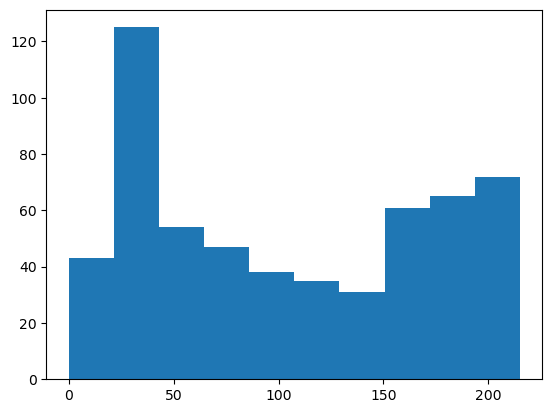

In [94]:
#log = pd.DataFrame(columns=['xxx'])
average = []
for i in range(10):
    log1 = []
    env = simpy.Environment()

    maquina = simpy.Resource(env, capacity=5)
    tecnic = simpy.Resource(env, capacity=3)

    env.process(arribades(env, maquina, tecnic, log1))
    env.run(until=7*24*60) # 7 dies en minuts
    average.append(np.mean(log1))

    if i == 9:
        # Fer un histograma de la cua
        plt.hist(log1)

print(f"Mitjana de tasques en cua: {np.mean(average)}")


### Exercici 3

Analitza la següent cadena de Markov:
[<center><img src=https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/notebooks/static/markov.png width=25%></center>](#bib_Konstantopoulos)

- Escriu la matriu de transició
- És irreductible?
- És aperiòdica?
- Si comencem a l'estat 1, quina probabilitat n'hi ha que ens trobem a cada un dels estats deprés de 3 passes?
- Troba la distribució d'estats estable si existeix.

In [95]:
M =np.array([[1/2, 1/3, 1/6],
             [3/4,  0 , 1/4],
             [ 0 ,  1 ,  0 ]])


# Irreducible: Es pot arribar a qualsevol estat desde qualsevol estat, en aquest cas des de 1 podem anar a 1,2 i 3. des de 2 tmb i desde 3 tmb
# Aperiodica: Pots tornar a qualsevol estat en un numero parell i imparell de passos. P.e puc tornar a 1 amb 3 i 2 passos. Tmb puc pels altres estats
# Si empezamos en 1:
p_0 = np.array([1, 0, 0])  # Estado inicial
M_3 = M @ M @ M  # Matriz de transición al tercer paso

p_3 = p_0 @ M_3  # Probabilidades de estar en cada estado al tercer paso
p_3
print(p_3)
# Por lo que habrá 0.5 de terminar en el estado 1, 0.3333 en el estado 2 y 0.1667 en el estado 3.

[0.5        0.33333333 0.16666667]


In [96]:
# Para la distribución de estados estables o estacionaria buscamos un q tal que q*M = q donde q_1 + q_2 + q_3 = 1
q1, q2, q3 = sp.symbols('q1 q2 q3')

eq1 = sp.Eq(q1, 1/2 * q1 + 3/4 * q2)
eq2 = sp.Eq(q2, 1/3 * q1 + 0 * q2 + 1 * q3)
eq3 = sp.Eq(q3, 1/6 * q1 + 1/4 * q2 + 0 * q3)
eq4 = sp.Eq(q1 + q2 + q3, 1)

sol = sp.solve([eq1, eq2, eq3, eq4], (q1, q2, q3))
print(sol)


{q1: 0.500000000000000, q2: 0.333333333333333, q3: 0.166666666666667}


In [97]:
q = np.array([sol[q1], sol[q2], sol[q3]])

q@M

array([0.500000000000000, 0.333333333333333, 0.166666666666667],
      dtype=object)

In [98]:
# un altre manera de fer el mateix

# matriu de transissió
M = np.array([[1/2, 1/3, 1/6],
     [3/4, 0, 1/4],
     [0, 1, 0]])

# es irreductible ja que podem anar d'un estat a qualsevol altre en un nombre finit de passos
# es aperiòdica ja que podem anar en camins parells i senar a cadascun dels estats

estat_inicial = np.array([1, 0, 0])  # estat inicial
pas1 = np.dot(estat_inicial, M)  # estat després d'un pas
pas2 = np.dot(pas1, M)  # estat després de dos passos
pas3 = np.dot(pas2, M)  # estat després de tres passos


print("Probabilitat d'estar al node 1 després d'un pas", pas3[0])
print("Probabilitat d'estar al node 2 després d'un pas", pas3[1]) 
print("Probabilitat d'estar al node 3 després d'un pas", pas3[2]) 

Probabilitat d'estar al node 1 després d'un pas 0.5
Probabilitat d'estar al node 2 després d'un pas 0.3333333333333333
Probabilitat d'estar al node 3 després d'un pas 0.16666666666666666


# Referències

- <a id='img_FaXToR'></a> Takis Konstantopoulos, **2019**. *Stochastic Processes I*

Copyright (C) 2022 Gabriel Jover Mañas

    Permission is granted to copy, distribute and/or modify this document
    under the terms of the GNU Free Documentation License, Version 1.3
    or any later version published by the Free Software Foundation;
    with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.
    A copy of the license is included in the section entitled "GNU
    Free Documentation License".

![GFDL][GFDL]

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

![GPL3][GPL3]

[GFDL]: static/gfdl-logo-small.png
[GPL3]: static/gplv3-127x51.png

In [ ]:
SV = sp.diff(xt, V).subs(valors)
SV = sp.lambdify(t,SV)
SV = SV(data['t (s)'])

SQ = sp.diff(xt, Q).subs(valors)
SQ = sp.lambdify(t,SQ)
SQ = SQ(data['t (s)'])

SO = sp.diff(xt, O).subs(valors)
SO = sp.lambdify(t,SO)
SO = SO(data['t (s)'])

SR = sp.diff(xt, R).subs(valors)
SR = sp.lambdify(t,SR)
SR = SR(data['t (s)'])

St = sp.diff(xt, t).subs(valors)
St = sp.lambdify(t,St)
St = St(data['t (s)'])